# homework 09: the return of the ten Arcs
### Yining Hua

## 1. write a simulator as a positive control
Write a function that simulates N=1000000 observed read counts, following the model specified above, for any Arc locus structure (i.e. lengths L_i) and any transcript abundances τ. (You can assume that there are 10 segments and isoforms, though my version of this script will allow that to vary too.)

Use your function to generate a test data set for known model parameters τ,L that you've chosen.

In [119]:
import numpy as np
import pandas as pd
import tqdm
np.random.seed(42)

default_len = [4,2,3,4,4,3,2,2,3,3]

In [71]:
def initialize_abundance_length(n_transcript, min_len, max_len):
    """Totally random"""
    abundance = list(np.random.dirichlet(np.ones(n_transcript),size=1)[0])
    lengths = list(np.random.randint(min_len, max_len+1, n_transcript))  ## remember python cuts off the right side of the range
    return abundance, lengths

def use_default_abundance_length(n_transcript):
    """Use the given lengths"""
    return list(np.random.dirichlet(np.ones(n_transcript),size=1)[0]), default_len

def generate_arc(len_transcripts):    
    transcripts = []
    segment = [i for i in range(len(len_transcripts))]
    for start_idx, trans_len in enumerate(len_transcripts):
        if start_idx+trans_len > len(len_transcripts):  ## if a new circle, add next circle
            transcripts.append(segment[start_idx:]+segment[:start_idx+trans_len - len(len_transcripts)])
        else: 
            transcripts.append(segment[start_idx:start_idx+trans_len])  
    return transcripts

def create_reads(trans_vec, abundance_vec, len_transcripts, N):    
    abundances = np.multiply(abundance_vec, len_transcripts)
    abundances = np.true_divide(abundances, sum(abundances))
    reads = []
    for i in tqdm.tqdm(range(N)):
        transcript = trans_vec[np.random.choice(len(trans_vec),p=abundances)]
        reads.append(np.random.choice(transcript))        
    return reads


In [41]:
from collections import Counter
def beautify(reads):
    df = pd.DataFrame.from_dict(Counter(reads), orient="index").reset_index()
    df.columns = ["read", "counts"]
    df["read_char"] = df.read.apply(lambda x: chr(ord('@')+x+1))
    df = df.sort_values("read",ignore_index=True)
    df["frequency"] = round(df.counts/df.counts.values.sum(),2)
    return df

In [121]:
trans_abundance, len_transcripts = initialize_abundance_length(10, min_len=2, max_len=4)
transcript_list = generate_arc(len_transcripts)
reads = create_reads(transcript_list, trans_abundance, len_transcripts, 1000000)
beautify(reads)

100%|██████████| 1000000/1000000 [00:24<00:00, 40074.33it/s]


,read,counts,read_char,frequency
0,0,59498,A,0.06
1,1,80702,B,0.08
2,2,59486,C,0.06
3,3,82660,D,0.08
4,4,65463,E,0.07
5,5,47579,F,0.05
6,6,120884,G,0.12
7,7,118486,H,0.12
8,8,163682,I,0.16
9,9,201560,J,0.20


In [122]:
## Use the deault lengths
abundances, len_transcripts = use_default_abundance_length(10)
transcripts = generate_arc(default_len)
reads = create_reads(transcripts, abundances, default_len, 1000000)
df = beautify(reads)
df

,read,counts,read_char,frequency
0,0,59498,A,0.06
1,1,80702,B,0.08
2,2,59486,C,0.06
3,3,82660,D,0.08
4,4,65463,E,0.07
5,5,47579,F,0.05
6,6,120884,G,0.12
7,7,118486,H,0.12
8,8,163682,I,0.16
9,9,201560,J,0.20


## 2. calculate the log likelihood
Write a function that calculates the log likelihood: the log probability of the observed data (the observed read counts rk) if the model and its parameters were known (i.e. τ,L), for a given locus structure of Arc. Explain the steps of your calculation.

Calculate and show the log likelihood of one of your generated test data sets, for your known parameter values.

Use Lestrade's approach (and his code, if you like) to estimate abundances of each Arc isoform in your test data set. Compare to your true τ. (Terrible, right?) Calculate and show the log likelihood given what Lestrade would estimate for the τ, compared to the log likelihood for the true τ in your positive control.

You should observe that the true τ parameter values give a much better log likelihood than the Lestrade et al. estimates, because the Lestrade et al. estimates are poor.

In [178]:
from scipy import special
def nuc_to_trans(abundances,len_transcripts):
    abundances = np.true_divide(abundances, len_transcripts)
    return np.true_divide(abundances, sum(abundances))
    
def trans_to_nuc(abundances,len_transcripts):
    abundances = np.multiply(abundances, len_transcripts)
    return np.true_divide(abundances, sum(abundances)) 
    
def calc_nll(reads, transcripts, abundances, len_transcripts): 
    '''The function assumes nucleotide abundances'''
    log_probs = []
    for read_idx, read in enumerate(unique_reads):  ## loop though all reads
        read_probs = []
        for idx, transcript in enumerate(transcripts):  ## for each read, loop through all transcripts
            if read in transcript:
                read_probs.append(np.log(abundances[idx]/len_transcripts[idx]))  ## to calc the read probs
        read_prob_sum = special.logsumexp(read_probs)*unique_counts[read_idx]  ## sum up and add to the total log prob list
        log_probs.append(read_prob_sum)
            
    return -np.sum(log_probs)  ## return the summed negative log likelihood


In [124]:
import string

T = 10
L = [4,2,3,4,4,3,2,2,3,3]
r = df.counts.tolist()
def Lestrade_est(reads, transcripts, lengths):
    """
    Copied from the script. Nice naming of variables. ABCDEFG
    """
    S = T    # S = R = T : there are T transcripts (Arc1..Arc10), S segments (A..J), R reads (a..j)
    R = T
    Slabel   = list(string.ascii_uppercase)[:S]               # ['A'..'J']        : the upper case labels for Arc locus segments 
    Tlabel   = [ "Arc{}".format(d) for d in range(1,T+1) ]    # ['Arc1'..'Arc10'] : the labels for Arc transcript isoforms
    Rlabel   = list(string.ascii_lowercase)[:T]               # ['a'..'j']        : lower case labels for reads


    # Count how often each segment A..J is used in the isoforms i
    # We'll use that to split observed read counts across the isoforms
    # that they might have come from.
    #
    segusage = np.zeros(S).astype(int)
    for i in range(T):
        for j in range(i,i+L[i]): 
            segusage[j%S] += 1


    # Naive analysis:
    #
    c  = np.zeros(T)
    for i in range(T):
        for k in range(i,i+L[i]):
            c[i] += (1.0 / float(segusage[k%S])) * float(r[k%S])  # For each read k, assume read k-> segment j,
                                                                  # and assign 1/usage count to each transcript
                                                                  # that contains segment j.
    Z       = np.sum(c)
    est_nu  = np.divide(c, Z)       # nucleotide abundance

    print(c)

    est_tau = np.divide(est_nu, L)  # convert to TPM, transcript abundance
    est_tau = np.divide(est_tau, np.sum(est_tau))

    # Print a table of the resulting estimates for tau
    for i in range(T):
        print ("{0:10s}  {1:5.3f}".format(Tlabel[i], est_tau[i]))
    
    return est_tau

In [125]:
les_abundances = Lestrade_est(reads, transcript_list, len_transcripts)

[ 94115.33333333  46729.33333333  69203.          95455.
  97523.16666667  75702.16666667  59842.5        111462.5
 202453.66666667 147513.33333333]
Arc1        0.068
Arc2        0.068
Arc3        0.067
Arc4        0.069
Arc5        0.071
Arc6        0.073
Arc7        0.087
Arc8        0.161
Arc9        0.195
Arc10       0.142


In [179]:
unique_reads = df.read.tolist()
unique_counts = df.counts.tolist()
true_nll = calc_nll(reads, transcripts, trans_to_nuc(abundances, default_len), default_len)
les_nll = calc_nll(reads, transcripts, trans_to_nuc(les_abundances, default_len), default_len)


In [180]:
print("The negative log-likelyhood of the true parameters is %.2f" %round(true_nll,2))
print("The negative log-likelyhood of Lestrade's parameters is %.2f" %round(les_nll,2))
print("Lestrade's nll is %.2f greater than the true llh."%round(np.abs(true_nll-les_nll),2))                                                             

The negative log-likelyhood of the true parameters is 2611101.60
The negative log-likelyhood of Lestrade's parameters is 2267657.38
Lestrade's nll is 343444.22 greater than the true llh.


So the negative log-likelyhood of Lestrade's parameters's is 343444.22 greater than the negative log-likelyhood of true parameters.

## 3. estimate isoform abundances by EM
Write a function that estimates unknown isoform abundances τi for each isoform Arc1..Arc10, given read counts rk and the structure of the Arc locus including the lengths Li, using expectation maximization.

Apply your function to the data in the Lestrade et al. supplementary data file. Show your estimated τi.

In [128]:
## read in the data
arc_df = pd.read_csv("w09-data.1.txt", header=0, index_col=None, delim_whitespace=True)
arc_df


,arc,trans,len,reads
0,Arc1,xxxxx,4,ABCD
1,Arc2,xxxxx,2,BC
2,Arc3,xxxxx,3,CDE
3,Arc4,xxxxx,4,DEFG
4,Arc5,xxxxx,4,EFGH
5,Arc6,xxxxx,3,FGH
6,Arc7,xxxxx,2,GH
7,Arc8,xxxxx,2,HI
8,Arc9,xxxxx,3,IJA
9,Arc10,xxxxx,3,JAB


In [129]:
## read in the data
read_df = pd.read_csv("w09-data.2.txt", header=0, index_col=None, delim_whitespace=True)
read_df = read_df.reset_index()
read_df

,index,read_char,counts
0,0,a,111446
1,1,b,76074
2,2,c,63285
3,3,d,124405
4,4,e,126593
5,5,f,123914
6,6,g,125104
7,7,h,89216
8,8,i,69544
9,9,j,90419


In [273]:
def EM(reads, transcripts, lengths, iterations):
    ## get some random values to start with
    trans_abundances = nuc_to_trans(initialize_abundance_length(len(transcripts), 1,1)[0], lengths)
    unique_reads, unique_counts = np.unique(reads, return_counts=True)
    nlls = []
    print("Training with %i iterations, threshold set at %f"%(iteration, threshold))
    for i in range(iterations):
        total_counts = np.zeros(10)   ## counts for the 10 reads at once
        for read_idx, read in enumerate(unique_reads):   ## same thing like what we did in the last question but
            read_probs, idxs = [], []    ## we'll keep track of the indices so we can use numpy to quickly add new reads in each run to the total reads
            for idx, transcript in enumerate(transcripts):
                if read in transcript:
                    idxs.append(idx)
                    read_probs.append(np.log(trans_abundances[idx]/lengths[idx]))
            read_probs = np.subtract(read_probs, special.logsumexp(read_probs))
            read_counts = np.multiply(np.exp(read_probs),unique_counts[read_idx])  ## add up
            np.add.at(total_counts, idxs, read_counts)
            
        trans_abundances = np.divide(total_counts, np.sum(total_counts))
        nll = calc_nll(reads, transcripts, trans_to_nuc(trans_abundances, lengths), lengths)
                                    
        if not nlls:
            nlls.append(nll)
            continue
        elif np.abs(np.subtract(nlls[-1], nll)) < threshold:
            nlls.append(nll)
            print("Training converged at step %i"%i)
            return trans_abundances, nlls
        else: 
            nlls.append(nll)
                                    
    print("Exceeded max iteration, killed and saved.")
    return trans_abundances, nlls

In [285]:
threshold = 0.001
iteration = 10000

reads = []
for read, counts in zip(read_df["index"],read_df.counts):
    reads += [read]*counts
transcripts = generate_arc(arc_df.len.tolist())
lengths = arc_df.len.tolist()

EM_abundances, EM_nlls = EM(reads, transcripts, lengths, iteration)


Training with 10000 iterations, threshold set at 0.001000
Training converged at step 2050


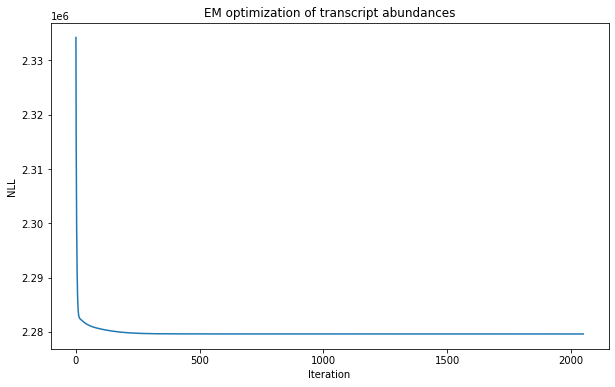

In [286]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(EM_nlls)
plt.xlabel("Iteration")
plt.ylabel("NLL")
plt.title("EM optimization of transcript abundances")
plt.show()


In [287]:
les_est_abundances = Lestrade_est(reads, transcripts, lengths)


[ 94115.33333333  46729.33333333  69203.          95455.
  97523.16666667  75702.16666667  59842.5        111462.5
 202453.66666667 147513.33333333]
Arc1        0.068
Arc2        0.068
Arc3        0.067
Arc4        0.069
Arc5        0.071
Arc6        0.073
Arc7        0.087
Arc8        0.161
Arc9        0.195
Arc10       0.142


In [299]:
df = pd.DataFrame(np.array([read_df.read_char.str.upper().tolist(), EM_abundances, les_abundances, np.abs(np.subtract(EM_abundances, les_est_abundances))]).T, 
                  columns=["Arc","EM abundance", "Les abundance", "Differences"])
df

,Arc,EM abundance,Les abundance,Differences
0,A,0.08411166246799551,0.06805198601052122,0.01605967645747429
1,B,0.008954558526382604,0.06757716996056576,0.05862261143418315
2,C,0.11333984585709321,0.06671816264988491,0.0466216832072083
3,D,0.26238419386984313,0.0690206589571055,0.1933635349127376
4,E,0.09287054161482344,0.07051608849108962,0.022354453123733825
5,F,0.10526742966718647,0.07298396700454259,0.03228346266264388
6,G,0.002426056266632222,0.08654064813033548,0.08411459186370325
7,H,0.05939087540082555,0.1611904080248572,0.10179953262403166
8,I,0.11954724245795834,0.19518426458003627,0.07563702212207793
9,J,0.15170759387125948,0.14221664619106136,0.00949094768019812


In [301]:
print("The negative log-likelyhood of EM optimized parameters is %.2f"%EM_nlls[-1])
print("The negative log-likelyhood of Les' parameters is %.2f"%les_nll)
print("Lestrade's nll is %.2f greater than the EM optimized llh."%np.abs(les_nll - EM_nlls[-1]))

The negative log-likelyhood of EM optimized parameters is 2177889.73
The negative log-likelyhood of Les' parameters is 2267657.38
Lestrade's nll is 89767.65 greater than the EM optimized llh.


### More questions in Q3
1. What are the most abundant two transcripts
2. and how much of the population do they account for? 
3. What are the least abundant two transcripts? 

In [306]:
df.sort_values("EM abundance", ascending=False)

,Arc,EM abundance,Les abundance,Differences
3,D,0.26238419386984313,0.0690206589571055,0.1933635349127376
9,J,0.15170759387125948,0.14221664619106136,0.00949094768019812
8,I,0.11954724245795834,0.19518426458003627,0.07563702212207793
2,C,0.11333984585709321,0.06671816264988491,0.0466216832072083
5,F,0.10526742966718647,0.07298396700454259,0.03228346266264388
4,E,0.09287054161482344,0.07051608849108962,0.022354453123733825
0,A,0.08411166246799551,0.06805198601052122,0.01605967645747429
7,H,0.05939087540082555,0.1611904080248572,0.10179953262403166
1,B,0.008954558526382604,0.06757716996056576,0.05862261143418315
6,G,0.002426056266632222,0.08654064813033548,0.08411459186370325


In [315]:
print("The most abundant two are Arc D and Arc J (4 and 10) as shown above. \n\
They accout for %.2f of the population."%(0.26238419386984313+0.15170759387125948))

The most abundant two are Arc D and Arc J (4 and 10) as shown above. 
They accout for 0.41 of the population.


In [316]:
print("The least abundant two are Arc B and Arc G (2 and 7) as shown above. \n\
They accout for %.2f of the population."%(0.008954558526382604+0.002426056266632222))

The least abundant two are Arc B and Arc G (2 and 7) as shown above. 
They accout for 0.01 of the population.


4. What do you think of Lestrade et al.'s conclusion that all 10 mRNA transcripts are expressed at about the same level? 
5. Explain why Lestrade's method's is worse.

<AxesSubplot:xlabel='Arc'>

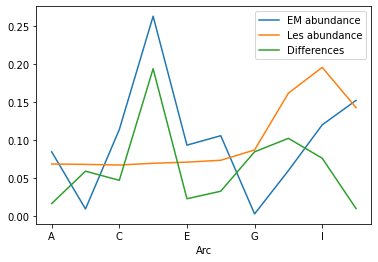

In [319]:
df.set_index("Arc").astype(float).plot()   ## I know this is a bad visualization but it's easy to do so...

So, although our visualization is pretty terrible, we can see that the transcripts are not uniformly distributed as predicted by the EM optimization algorithm (See the blue line above). From the negative log-likelyhood test we also see that Lestrade's total NLL is 89767.65 greater than that of the EM algorithm, meaning that Les did a pretty bad job in estimating the parameters. And talking about why, Lestrade simply used ```1/L_i``` when calculating the necleotide abundance, assuming a uniform distribution, which is not the case, while we considered the actual abundance.